In [157]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458

In [264]:
working_folder = 'eSR/2RF/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [265]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [266]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6

nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print(bucket_height)
print(Ek)
print(Qs)

269.8121242542218
10015579420.0
0.05414679003395008


In [267]:
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh/(1+1j*QL*(omega/omega0-omega0/omega))

In [270]:
eps0 = 8.854e-12
#r0 = (79*1.6e-19)**2/(197*1.7e-27*3e8*3e8) # gold
#r0 = (1*1.6e-19)**2/(1*1.7e-27*3e8*3e8) # Proton
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = nBunch # number of samples 

mu = 0#h[0]%nBunch # 

ps = np.array([float(i) for i in range(-pmax,pmax)])
ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

# for the calculation of real part of Omega
p_M_omega0 = ps*nBunch*2*np.pi*f0
Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
delta_omegas = factor1*np.sum(p_M_omega0*np.imag(Zs0))
omegas = Qs*2*pi*f0+delta_omegas

omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

# for the calculation of the imaginary part of Omega
omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
print(deltaOmegaRe)
print(deltaOmegaIm)

36607.57398772778
-1311.2425534627976


In [271]:
(ps*nBunch+mu)*f0

array([-1.24144427e+11, -1.24045900e+11, -1.23947373e+11, ...,
        1.23848845e+11,  1.23947373e+11,  1.24045900e+11])

In [272]:
datafilepar = 'first.bin'
datafilepar = os.path.join(cwd,datafilepar)
with open(datafilepar, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
datapar = np.array([struct.unpack('dd',fileContent[i*16:(i+1)*16]) for i in range(int(len(fileContent)/16))]).T
first_dt = np.array(datapar[0])
first_gamma = np.array(datapar[1])

[    0.         -1307.96837867    -5.        ]
[[  0.           0.          -0.        ]
 [  0.           0.          -0.        ]
 [ -0.          -0.         921.58929644]]
Fitted Tau =  -0.0007645444769975401
TauAnalytical =  -0.0007626354081928992
TauSimplified  =  2.704850990512867e-06
Fitted Tau     =  -0.0007645444769975401
Tau_including_artificial_Damping_Term =  -0.0005764850522045518
eta =  0.001040580123244694
Qs =  0.05414679003395008
f0 =  78196.2883627698
fs =  4234.078007413111


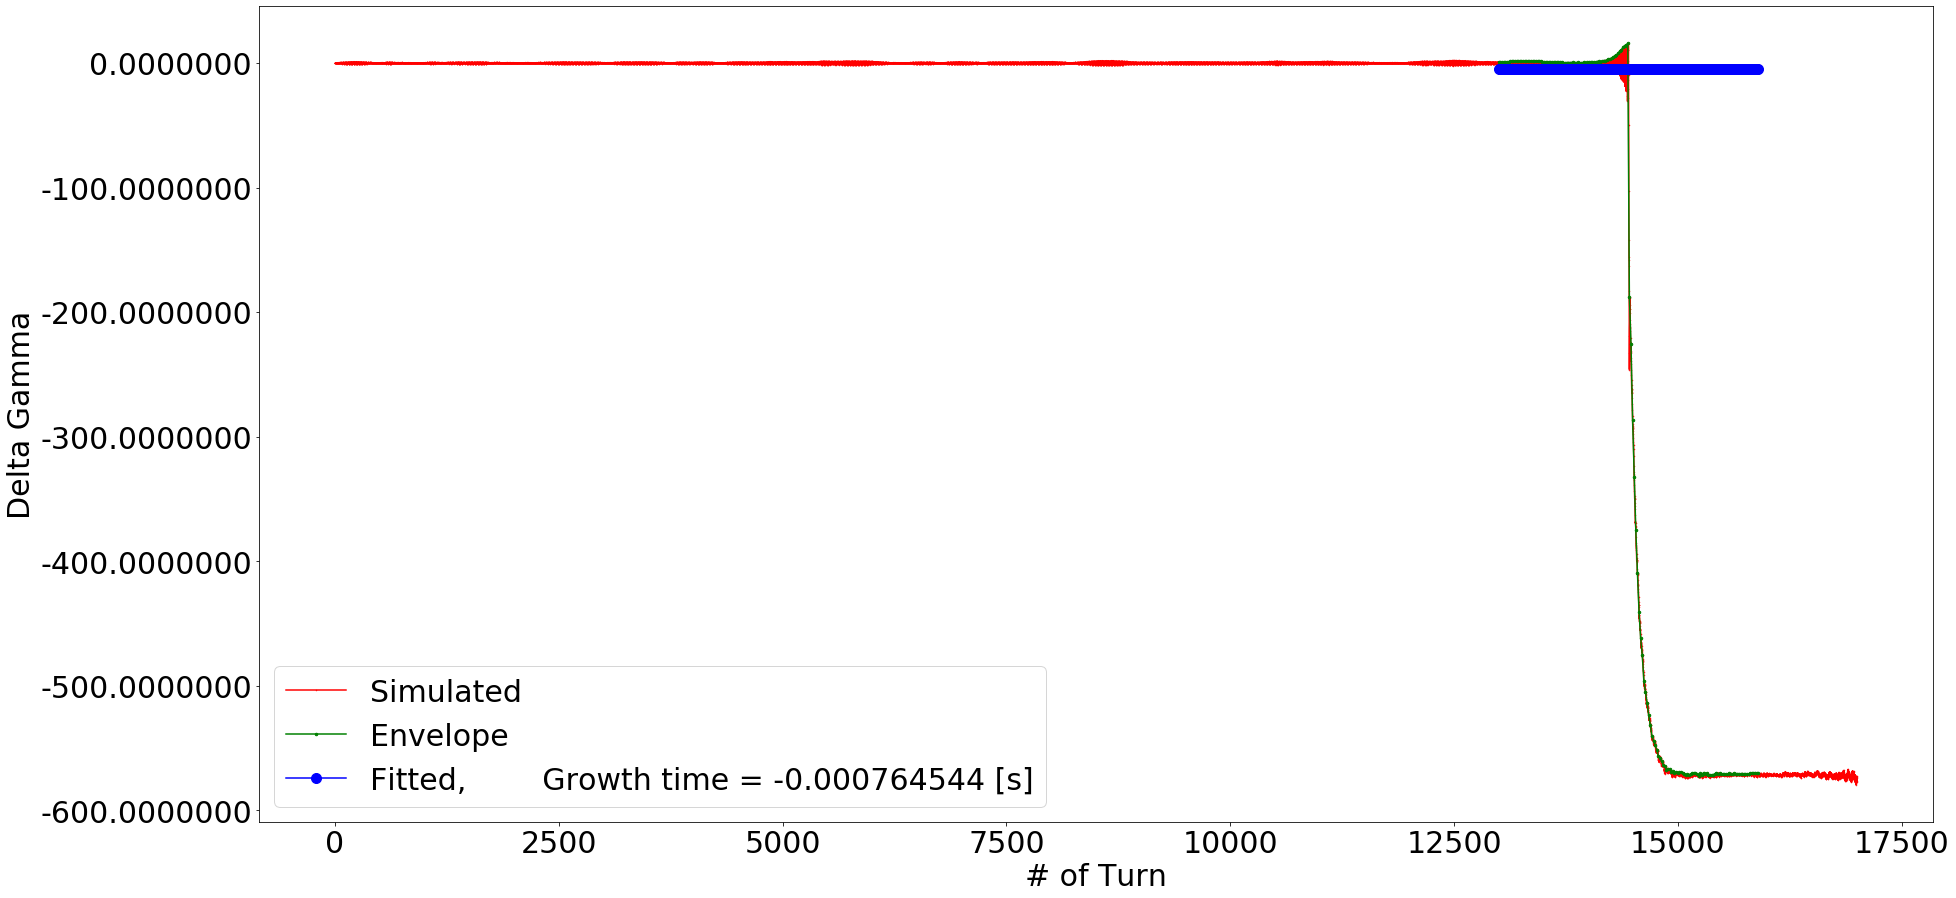

In [273]:
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c
if 1:
    startTurn = 13000
    endTurn = 16000
    delta_gamma_env = np.zeros(int((endTurn-startTurn)*Qs))
    TTurns = int(1/Qs) # numbers of turns per synchrotron oscillation
    delta_gamma_turn = np.array([i*TTurns+startTurn for i in range(len(delta_gamma_env))])
    delta_gamma_time = delta_gamma_turn*T0
    for i in range(len(delta_gamma_env)):
        delta_gamma_env[i] = np.max(first_gamma[i*TTurns+startTurn:(i+1)*TTurns+startTurn])-Gamma0
    popt, pcov = curve_fit(func_exp_fit, delta_gamma_time, \
                           delta_gamma_env,bounds=([-1e-1,deltaOmegaIm*3,-5], \
                                                   [1e-1, deltaOmegaIm*0.5, 5]),\
                           maxfev=2000000)
    print(popt)
    print(pcov)

    print("Fitted Tau = ",1/popt[1])
    delta_gamma_fitted = popt[0]*np.exp(popt[1]*delta_gamma_time)+popt[2]
    # Analytical
    print("TauAnalytical = ",1/deltaOmegaIm)
    TauInver = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)*(h[mainRF]*2*np.pi*f0+f0*Qs*2*np.pi)*R[mainRF]
    print("TauSimplified  = ",1/TauInver)
    TauInver = deltaOmegaIm
    print("Fitted Tau     = ",1/popt[1])
    TauInver = (deltaOmegaIm-Qs/Ek_damp/2/T0)
    print("Tau_including_artificial_Damping_Term = ",1/TauInver)

    temp_time = np.array([i*T0 for i in range(len(first_gamma))])

    analy = popt[0]*np.exp(TauInver*delta_gamma_time)+popt[2]
    rng1 =  0
    rng2 = 20000#int(nTurns-1)

    step1 = 1

    fig1,axes1 = plt.subplots(1,1)

    axes1.plot(first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=1)
    axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_env[rng1:int(rng2/TTurns):step1],'g.-',ms=5)
    axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],delta_gamma_fitted[rng1:int(rng2/TTurns):step1],'b.-',ms=20)
    #axes1.plot(delta_gamma_turn[rng1:int(rng2/TTurns):step1],analy[rng1:int(rng2/TTurns):step1],'y.-',ms=30)
    #axes1.set_yscale('log')

    #axes1.plot(first_dt[rng1:rng2:step1],first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=10)

    #axes1.plot(first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)
    #axes1.plot(first_dt[rng1:rng1+10:step1],first_gamma[rng1:rng1+10:step1]-Gamma0,'g.-',ms=30)

    #axes1.plot(first_gamma[rng2-1000:rng2:step1]-Gamma0,'b.-',ms=30)

    axes1.set_xlabel('# of Turn',fontsize=30)
    axes1.set_ylabel('Delta Gamma',fontsize=30)
    axes1.tick_params(labelsize=30)
    y_labels = axes1.get_yticks()
    axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.7f'))

    axes1.legend(['Simulated','Envelope',f'Fitted,        Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
    #axes1.axhline(y=bucket_height)
    #axes1.axhline(y=-bucket_height)

    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    fn_Bench = os.path.join(cwd,'Bench.jpg')
    plt.savefig(fn_Bench,bbox_inches='tight')
    print('eta = ',eta)
    print('Qs = ',Qs)
    print('f0 = ',f0)
    print('fs = ',Qs*f0)
    plt.show()

4234.078007413111
0.05414679003395008


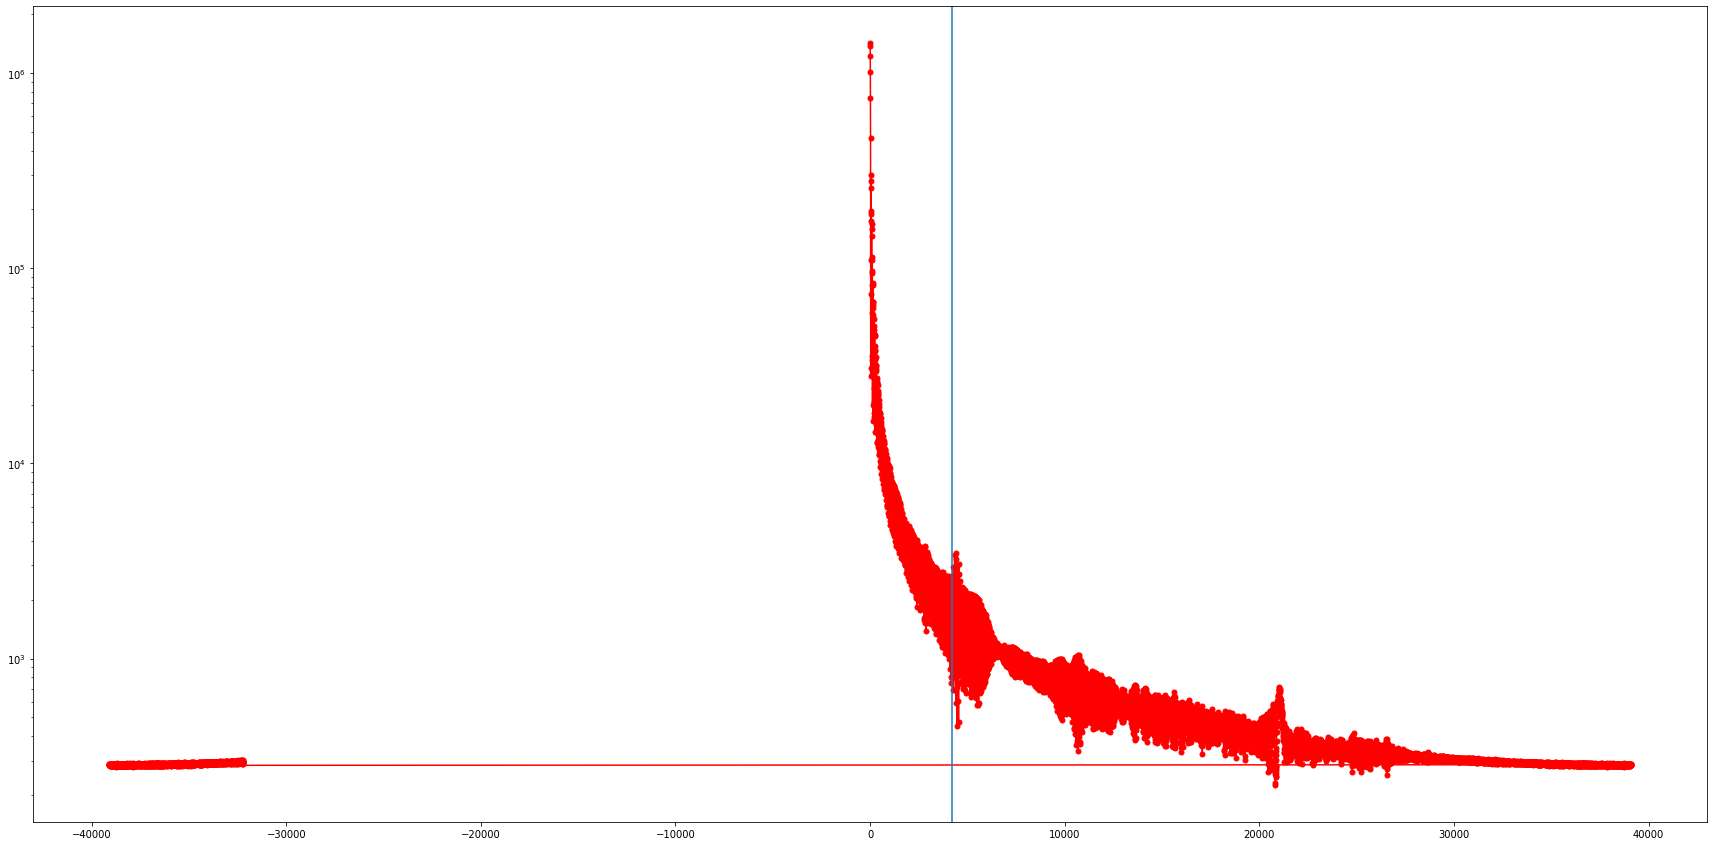

In [274]:
gamma_fft = np.fft.fft(first_gamma-Gamma0)
w = np.fft.fftfreq(len(first_gamma),d=1/f0)
rng1 =  0
rng2 = int(10000)
step1 = 1

fig1,axes1 = plt.subplots(1,1)
axes1.plot(w[rng1:rng2],np.abs(gamma_fft[rng1:rng2]),'r.-',ms=10)
axes1.set_yscale('log')
axes1.axvline(x=Qs*f0)

fig1.set_figheight(15)
fig1.set_figwidth(30)
print(Qs*f0)
print(Qs)
plt.show()

eta =  0.001040580123244694
Qs =  0.05414679003395008
f0 =  78196.2883627698
fs =  4234.078007413111


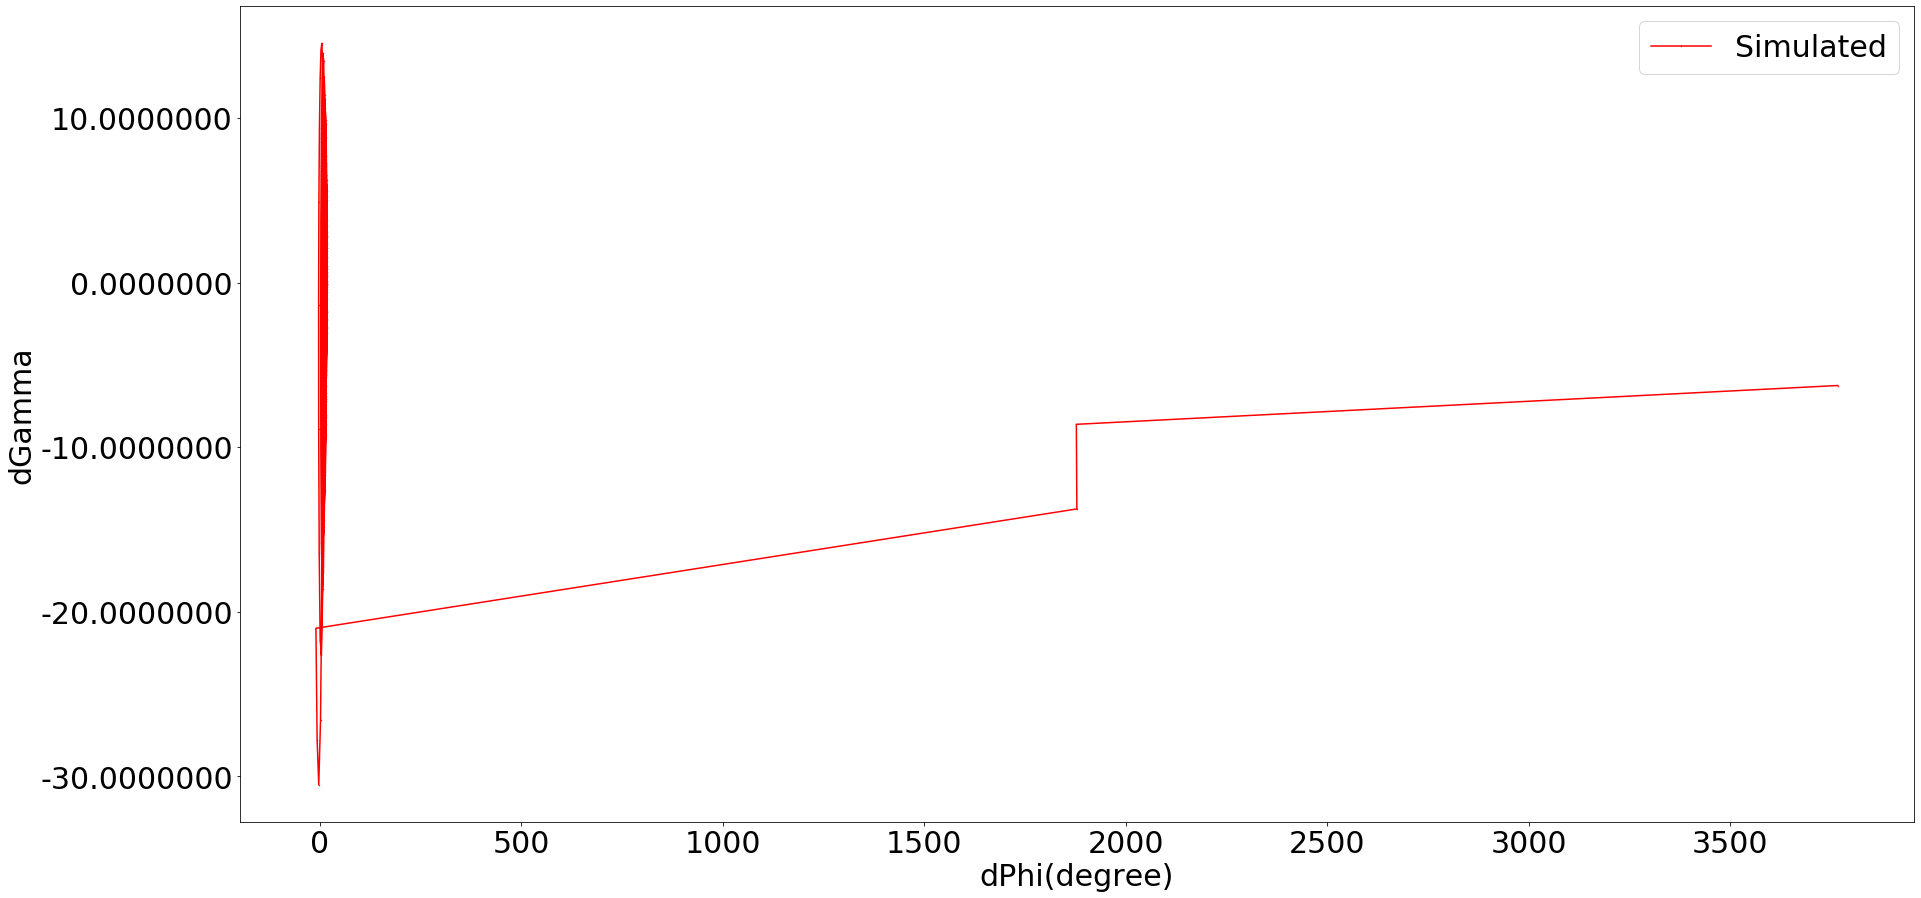

In [275]:
if 0:
    startTurn = 12800
    endTurn = 13100
    delta_gamma_env = np.zeros(int((endTurn-startTurn)*Qs))
    TTurns = int(1/Qs) # numbers of turns per synchrotron oscillation
    delta_gamma_turn = np.array([i*TTurns+startTurn for i in range(len(delta_gamma_env))])
    delta_gamma_time = delta_gamma_turn*T0
    for i in range(len(delta_gamma_env)):
        delta_gamma_env[i] = np.max(first_gamma[i*TTurns+startTurn:(i+1)*TTurns+startTurn])-Gamma0
    popt, pcov = curve_fit(func_exp_fit, delta_gamma_time, \
                           delta_gamma_env,bounds=([-1e-1,deltaOmegaIm*3,-5], \
                                                   [1e-1, deltaOmegaIm*0.5, 5]),\
                           maxfev=2000000)
    print(popt)
    print(pcov)

    print("Fitted Tau = ",1/popt[1])
    delta_gamma_fitted = popt[0]*np.exp(popt[1]*delta_gamma_time)+popt[2]
    # Analytical
    print("TauAnalytical = ",1/deltaOmegaIm)
    TauInver = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)*(h[mainRF]*2*np.pi*f0+f0*Qs*2*np.pi)*R[mainRF]
    print("TauSimplified  = ",1/TauInver)
    TauInver = deltaOmegaIm
    print("Fitted Tau     = ",1/popt[1])
    TauInver = (deltaOmegaIm-Qs/Ek_damp/2/T0)
    print("Tau_including_artificial_Damping_Term = ",1/TauInver)

    temp_time = np.array([i*T0 for i in range(len(first_gamma))])

    analy = popt[0]*np.exp(TauInver*delta_gamma_time)+popt[2]
rng1 =  14000
rng2 = 14443#int(nTurns-1)

step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(first_dt[rng1:rng2:step1]/T0*h[0]*360-180,first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=1)

axes1.set_xlabel('dPhi(degree)',fontsize=30)
axes1.set_ylabel('dGamma',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.7f'))

axes1.legend(['Simulated','Envelope',f'Fitted,        Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
#axes1.axhline(y=bucket_height)
#axes1.axhline(y=-bucket_height)

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_Bench = os.path.join(cwd,'Synch_Osci.jpg')
plt.savefig(fn_Bench,bbox_inches='tight')
print('eta = ',eta)
print('Qs = ',Qs)
print('f0 = ',f0)
print('fs = ',Qs*f0)
plt.show()

eta =  0.001040580123244694
Qs =  0.05414679003395008
f0 =  78196.2883627698
fs =  4234.078007413111


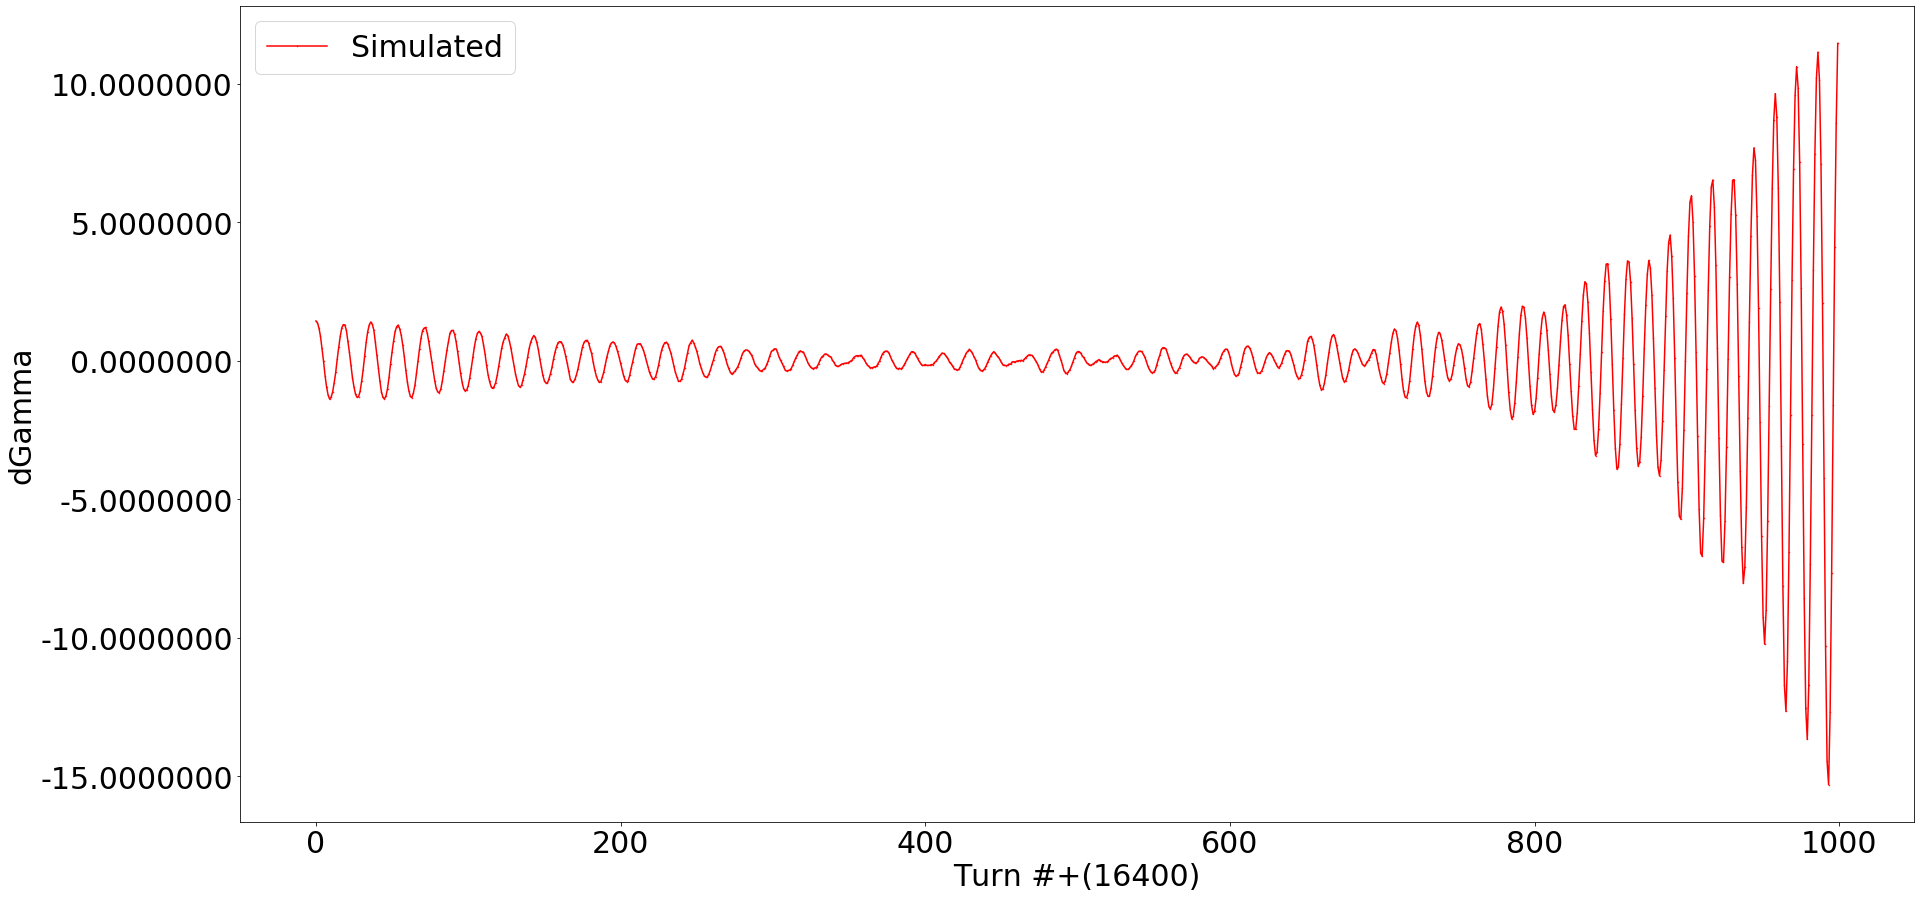

In [276]:
rng1 =  13400
rng2 = 14400#int(nTurns-1)

step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(first_gamma[rng1:rng2:step1]-Gamma0,'r.-',ms=1)

axes1.set_xlabel('Turn #+('+str(rng1+nfill)+')',fontsize=30)
axes1.set_ylabel('dGamma',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.7f'))

axes1.legend(['Simulated','Envelope',f'Fitted,        Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
#axes1.axhline(y=bucket_height)
#axes1.axhline(y=-bucket_height)

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_Bench = os.path.join(cwd,'dGamma_vs_turn.jpg')
plt.savefig(fn_Bench,bbox_inches='tight')
print('eta = ',eta)
print('Qs = ',Qs)
print('f0 = ',f0)
print('fs = ',Qs*f0)
plt.show()

eta =  0.001040580123244694
Qs =  0.05414679003395008
f0 =  78196.2883627698
fs =  4234.078007413111


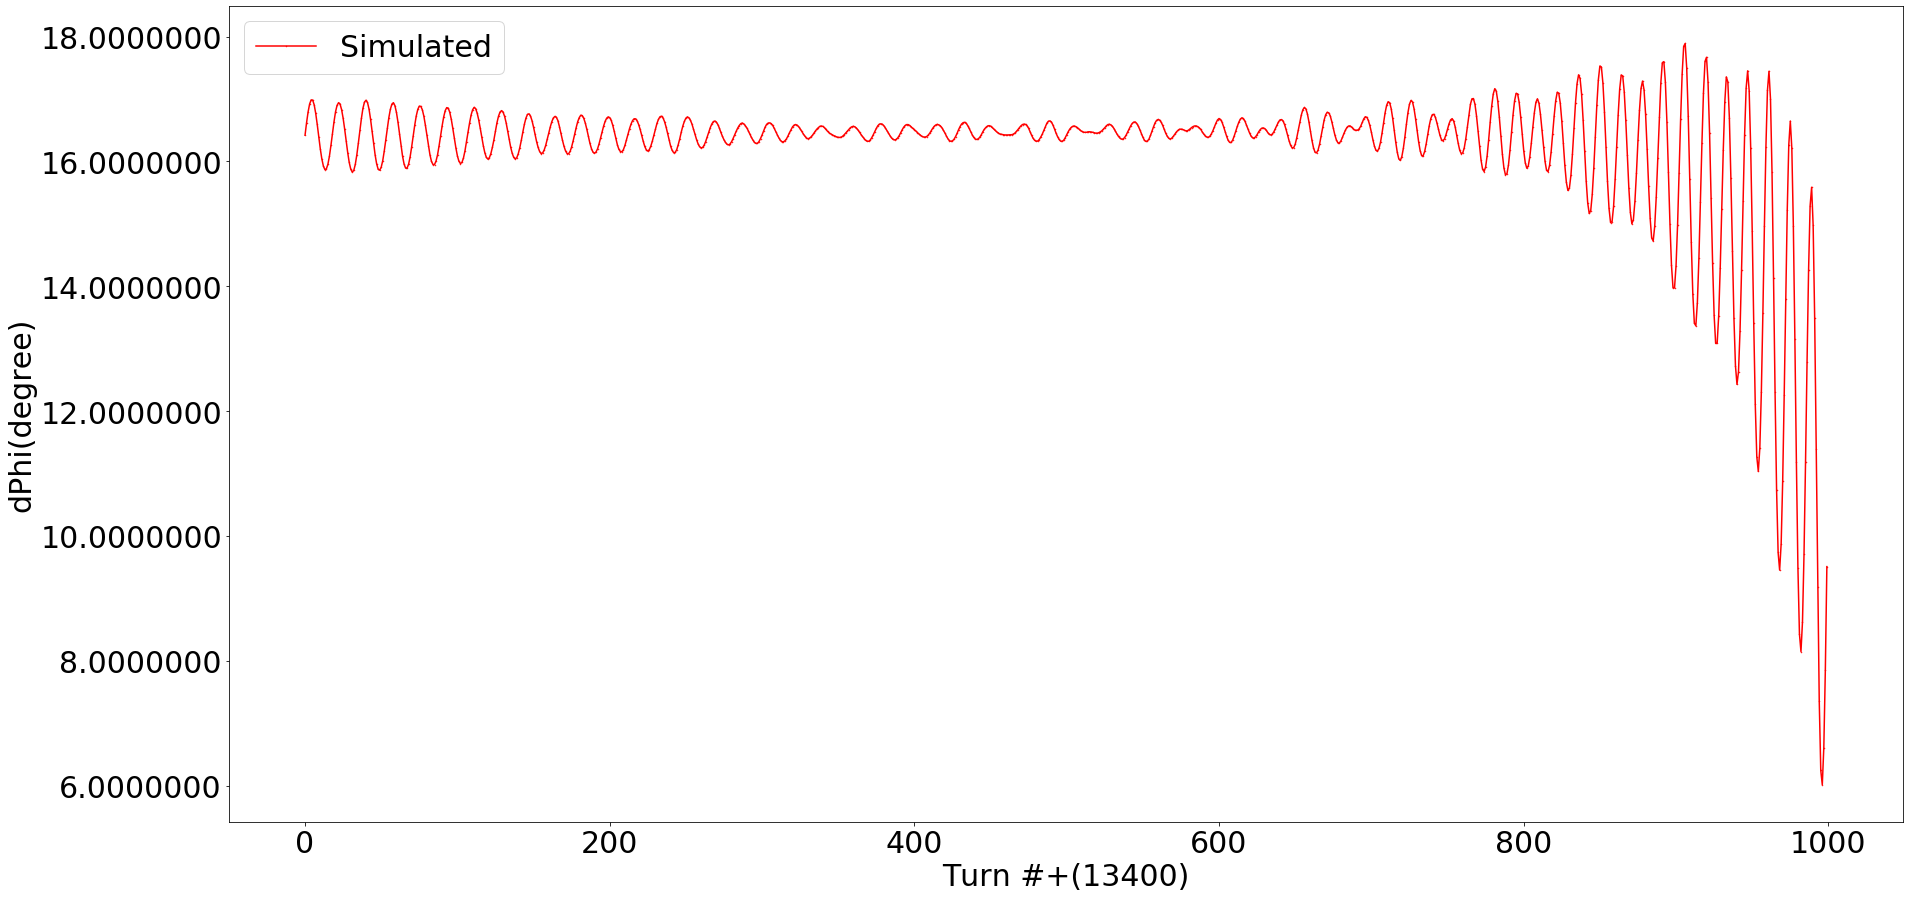

In [277]:
rng1 =  13400
rng2 = 14400#int(nTurns-1)

step1 = 1

fig1,axes1 = plt.subplots(1,1)

axes1.plot(first_dt[rng1:rng2:step1]/T0*h[0]*360-180,'r.-',ms=1)

axes1.set_xlabel('Turn #+('+str(rng1)+')',fontsize=30)
axes1.set_ylabel('dPhi(degree)',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.7f'))

axes1.legend(['Simulated','Envelope',f'Fitted,        Growth time = {(1/popt[1]):{1}.{6}} [s]','Analytical,  Growth time = '+f"{1/TauInver:{1}.{6}}"+' [s]'],fontsize=30)
#axes1.axhline(y=bucket_height)
#axes1.axhline(y=-bucket_height)

fig1.set_figheight(15)
fig1.set_figwidth(30)
fn_Bench = os.path.join(cwd,'dPhi_vs_turn.jpg')
plt.savefig(fn_Bench,bbox_inches='tight')
print('eta = ',eta)
print('Qs = ',Qs)
print('f0 = ',f0)
print('fs = ',Qs*f0)
plt.show()

In [278]:
eps0 = 8.854e-12
#r0 = (79*1.6e-19)**2/(197*1.7e-27*3e8*3e8) # gold
#r0 = (1*1.6e-19)**2/(1*1.7e-27*3e8*3e8) # Proton
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 200*nBunch # number of samples 

mus = np.array([i for i in range(nBunch)])#200#h[0]%nBunch # 
delta_omega_Re = np.zeros(nBunch)
delta_omega_Im = np.zeros(nBunch)
i=0
for mu in mus:
    ps = np.array([float(i) for i in range(-pmax,pmax)])
    ps[pmax]=1e-16 # get rid of the zero point to avoid 1/0 problem in python

    # for the calculation of real part of Omega
    p_M_omega0 = ps*nBunch*2*np.pi*f0
    Zs0 = np.array([Zparallel(R[i],QL[i],omegac[i],p_M_omega0) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*Qs*f0*2*np.pi)
    delta_omegas = 0*factor1*np.sum(p_M_omega0*np.imag(Zs0)) # this is zero if optimumly compensated 
    omegas = Qs*2*pi*f0+delta_omegas

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas)
    Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas)
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))

    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[i] = deltaOmegaRe
    delta_omega_Im[i] = deltaOmegaIm
    i+=1
    print(i,delta_omegas,';',deltaOmegaRe,';',deltaOmegaIm)


1 -0.0 ; 244807.24751802304 ; -12515.43406745134
2 -0.0 ; 197438.85836878655 ; -0.2345360784710719
3 -0.0 ; 197474.411781436 ; -0.03080495029785729
4 -0.0 ; 197481.35069620807 ; -0.009000399614843026
5 -0.0 ; 197483.82778719784 ; -0.003631161227774662
6 -0.0 ; 197484.9865129442 ; -0.001731383620682915
7 -0.0 ; 197485.62012919592 ; -0.0009062019863684283
8 -0.0 ; 197486.00392397883 ; -0.0004974589253348556
9 -0.0 ; 197486.25385186882 ; -0.00027584856746364945
10 -0.0 ; 197486.42563730406 ; -0.00014765424599247606
11 -0.0 ; 197486.54876072862 ; -6.989504777244581e-05
12 -0.0 ; 197486.6400058399 ; -2.1061145718411364e-05
13 -0.0 ; 197486.70949813648 ; 1.0373695886773516e-05
14 -0.0 ; 197486.7636402826 ; 3.0934641181276034e-05
15 -0.0 ; 197486.80664155353 ; 4.448568958032417e-05
16 -0.0 ; 197486.8413614189 ; 5.3402239488619224e-05
17 -0.0 ; 197486.8697975125 ; 5.9191297001518055e-05
18 -0.0 ; 197486.89337954056 ; 6.283485685889666e-05
19 -0.0 ; 197486.9131525683 ; 6.498760025870488e-05
20 

155 -0.0 ; 197487.07470100877 ; 1.2375771884188952e-05
156 -0.0 ; 197487.0747298885 ; 1.2288411738934966e-05
157 -0.0 ; 197487.07475821365 ; 1.2202095999867697e-05
158 -0.0 ; 197487.07478599835 ; 1.2116805134294583e-05
159 -0.0 ; 197487.07481325616 ; 1.203252008907461e-05
160 -0.0 ; 197487.07484000025 ; 1.194922227607192e-05
161 -0.0 ; 197487.0748662435 ; 1.1866893558139188e-05
162 -0.0 ; 197487.0748919982 ; 1.1785516235623652e-05
163 -0.0 ; 197487.07491727645 ; 1.1705073033310077e-05
164 -0.0 ; 197487.07494208985 ; 1.1625547087859166e-05
165 -0.0 ; 197487.07496644973 ; 1.1546921935670194e-05
166 -0.0 ; 197487.07499036688 ; 1.1469181501168309e-05
167 -0.0 ; 197487.07501385218 ; 1.1392310085512069e-05
168 -0.0 ; 197487.07503691578 ; 1.1316292355661456e-05
169 -0.0 ; 197487.07505956772 ; 1.1241113333854587e-05
170 -0.0 ; 197487.07508181763 ; 1.1166758387423957e-05
171 -0.0 ; 197487.075103675 ; 1.1093213218962526e-05
172 -0.0 ; 197487.07512514901 ; 1.1020463856824758e-05
173 -0.0 ; 197487

309 -0.0 ; 197487.07637702354 ; 5.200687794281702e-06
310 -0.0 ; 197487.07638055552 ; 5.174851667784635e-06
311 -0.0 ; 197487.07638405185 ; 5.149147221232266e-06
312 -0.0 ; 197487.07638751308 ; 5.123573136759017e-06
313 -0.0 ; 197487.07639093965 ; 5.0981281129887516e-06
314 -0.0 ; 197487.07639433193 ; 5.0728108647714645e-06
315 -0.0 ; 197487.0763976904 ; 5.047620122925582e-06
316 -0.0 ; 197487.07640101548 ; 5.022554633986748e-06
317 -0.0 ; 197487.07640430756 ; 4.9976131599577116e-06
318 -0.0 ; 197487.07640756704 ; 4.972794478067834e-06
319 -0.0 ; 197487.07641079434 ; 4.948097380532167e-06
320 -0.0 ; 197487.07641398985 ; 4.923520674318687e-06
321 -0.0 ; 197487.07641715396 ; 4.899063180918357e-06
322 -0.0 ; 197487.07642028708 ; 4.874723736117418e-06
323 -0.0 ; 197487.0764233895 ; 4.850501189779452e-06
324 -0.0 ; 197487.07642646172 ; 4.826394405624603e-06
325 -0.0 ; 197487.07642950394 ; 4.802402261018575e-06
326 -0.0 ; 197487.07643251674 ; 4.7785236467618296e-06
327 -0.0 ; 197487.07643550

462 -0.0 ; 197487.0766661164 ; 2.2525259771260115e-06
463 -0.0 ; 197487.0766670029 ; 2.237496646648352e-06
464 -0.0 ; 197487.0766678816 ; 2.222500533849802e-06
465 -0.0 ; 197487.07666875233 ; 2.2075373435674275e-06
466 -0.0 ; 197487.0766696154 ; 2.1926067827431992e-06
467 -0.0 ; 197487.07667047068 ; 2.177708560399763e-06
468 -0.0 ; 197487.07667131835 ; 2.162842387615682e-06
469 -0.0 ; 197487.07667215844 ; 2.1480079775000506e-06
470 -0.0 ; 197487.07667299095 ; 2.13320504517022e-06
471 -0.0 ; 197487.076673816 ; 2.118433307725592e-06
472 -0.0 ; 197487.07667463348 ; 2.1036924842260194e-06
473 -0.0 ; 197487.07667544368 ; 2.0889822956673756e-06
474 -0.0 ; 197487.07667624648 ; 2.0743024649589877e-06
475 -0.0 ; 197487.076677042 ; 2.059652716900886e-06
476 -0.0 ; 197487.07667783028 ; 2.0450327781606584e-06
477 -0.0 ; 197487.0766786114 ; 2.0304423772522832e-06
478 -0.0 ; 197487.07667938527 ; 2.0158812445131933e-06
479 -0.0 ; 197487.07668015207 ; 2.0013491120830915e-06
480 -0.0 ; 197487.076680911

615 -0.0 ; 197487.0767322246 ; 2.0001630828179255e-07
616 -0.0 ; 197487.0767322885 ; 1.874608613575767e-07
617 -0.0 ; 197487.07673234824 ; 1.749077425042367e-07
618 -0.0 ; 197487.07673240374 ; 1.6235679543596624e-07
619 -0.0 ; 197487.07673245517 ; 1.4980786397539708e-07
620 -0.0 ; 197487.07673250246 ; 1.3726079204482532e-07
621 -0.0 ; 197487.0767325456 ; 1.2471542365898474e-07
622 -0.0 ; 197487.07673258457 ; 1.1217160291694402e-07
623 -0.0 ; 197487.0767326195 ; 9.962917399454858e-08
624 -0.0 ; 197487.0767326502 ; 8.708798113690082e-08
625 -0.0 ; 197487.07673267688 ; 7.454786864983837e-08
626 -0.0 ; 197487.07673269935 ; 6.20086808933234e-08
627 -0.0 ; 197487.07673271772 ; 4.947026227273873e-08
628 -0.0 ; 197487.07673273192 ; 3.693245723184179e-08
629 -0.0 ; 197487.076732742 ; 2.4395110244747907e-08
630 -0.0 ; 197487.07673274793 ; 1.1858065808038904e-08
631 -0.0 ; 197487.07673274985 ; -6.788315663778513e-10
632 -0.0 ; 197487.07673274758 ; -1.3215737359543984e-08
633 -0.0 ; 197487.0767327

764 -0.0 ; 197487.07669336305 ; -1.7319230563129063e-06
765 -0.0 ; 197487.0766927221 ; -1.745955442490469e-06
766 -0.0 ; 197487.07669207486 ; -1.7600120805194297e-06
767 -0.0 ; 197487.07669142124 ; -1.7740932079908603e-06
768 -0.0 ; 197487.07669076134 ; -1.7881990639302831e-06
769 -0.0 ; 197487.07669009492 ; -1.802329888815489e-06
770 -0.0 ; 197487.07668942216 ; -1.8164859245946977e-06
771 -0.0 ; 197487.07668874282 ; -1.830667414703461e-06
772 -0.0 ; 197487.076688057 ; -1.8448746040845128e-06
773 -0.0 ; 197487.07668736458 ; -1.8591077392042217e-06
774 -0.0 ; 197487.0766866655 ; -1.8733670680728507e-06
775 -0.0 ; 197487.07668595982 ; -1.8876528402622494e-06
776 -0.0 ; 197487.07668524742 ; -1.9019653069250704e-06
777 -0.0 ; 197487.07668452826 ; -1.916304720814499e-06
778 -0.0 ; 197487.07668380233 ; -1.9306713363026015e-06
779 -0.0 ; 197487.07668306958 ; -1.9450654094013255e-06
780 -0.0 ; 197487.07668232988 ; -1.959487197781248e-06
781 -0.0 ; 197487.07668158328 ; -1.9739369607920424e-06
7

914 -0.0 ; 197487.07649172208 ; -4.282168224869336e-06
915 -0.0 ; 197487.07648927605 ; -4.3038149615281985e-06
916 -0.0 ; 197487.0764868071 ; -4.3255539379807555e-06
917 -0.0 ; 197487.07648431504 ; -4.347386014977465e-06
918 -0.0 ; 197487.07648179957 ; -4.3693120629456375e-06
919 -0.0 ; 197487.07647926034 ; -4.391332962131865e-06
920 -0.0 ; 197487.0764766972 ; -4.413449602745819e-06
921 -0.0 ; 197487.0764741098 ; -4.435662885108921e-06
922 -0.0 ; 197487.0764714979 ; -4.457973719801385e-06
923 -0.0 ; 197487.07646886123 ; -4.480383027816647e-06
924 -0.0 ; 197487.07646619948 ; -4.50289174071382e-06
925 -0.0 ; 197487.07646351235 ; -4.525500800777767e-06
926 -0.0 ; 197487.07646079955 ; -4.548211161178101e-06
927 -0.0 ; 197487.07645806082 ; -4.57102378613145e-06
928 -0.0 ; 197487.07645529576 ; -4.593939651070221e-06
929 -0.0 ; 197487.07645250417 ; -4.616959742809364e-06
930 -0.0 ; 197487.0764496857 ; -4.640085059718952e-06
931 -0.0 ; 197487.07644684 ; -4.663316611899592e-06
932 -0.0 ; 197487

1065 -0.0 ; 197487.0755579626 ; -9.431313120444617e-06
1066 -0.0 ; 197487.07554371786 ; -9.487974031897076e-06
1067 -0.0 ; 197487.07552925093 ; -9.545165913530537e-06
1068 -0.0 ; 197487.07551455716 ; -9.602896944915582e-06
1069 -0.0 ; 197487.07549963193 ; -9.661175472542964e-06
1070 -0.0 ; 197487.07548447035 ; -9.720010014107092e-06
1071 -0.0 ; 197487.07546906744 ; -9.779409262896956e-06
1072 -0.0 ; 197487.0754534181 ; -9.83938209233363e-06
1073 -0.0 ; 197487.07543751708 ; -9.899937560657899e-06
1074 -0.0 ; 197487.07542135898 ; -9.961084915731688e-06
1075 -0.0 ; 197487.0754049382 ; -1.0022833600039087e-05
1076 -0.0 ; 197487.07538824916 ; -1.0085193255796612e-05
1077 -0.0 ; 197487.07537128596 ; -1.0148173730249562e-05
1078 -0.0 ; 197487.07535404258 ; -1.0211785081139932e-05
1079 -0.0 ; 197487.07533651296 ; -1.027603758233316e-05
1080 -0.0 ; 197487.07531869065 ; -1.0340941729644552e-05
1081 -0.0 ; 197487.07530056912 ; -1.0406508246830508e-05
1082 -0.0 ; 197487.07528214168 ; -1.0472748091

1211 -0.0 ; 197487.05555100337 ; -3.799474247636147e-05
1212 -0.0 ; 197487.05466753663 ; -3.868649816384037e-05
1213 -0.0 ; 197487.05372821513 ; -3.940093372790535e-05
1214 -0.0 ; 197487.0527282293 ; -4.013897085966456e-05
1215 -0.0 ; 197487.05166224085 ; -4.090155218516817e-05
1216 -0.0 ; 197487.05052431082 ; -4.1689635412234385e-05
1217 -0.0 ; 197487.0493078172 ; -4.250418533113575e-05
1218 -0.0 ; 197487.0480053579 ; -4.334616305646762e-05
1219 -0.0 ; 197487.04660863805 ; -4.4216511731781636e-05
1220 -0.0 ; 197487.04510833786 ; -4.51161376790313e-05
1221 -0.0 ; 197487.0434939565 ; -4.604588569125181e-05
1222 -0.0 ; 197487.04175362783 ; -4.700650676620616e-05
1223 -0.0 ; 197487.0398739016 ; -4.7998616062627274e-05
1224 -0.0 ; 197487.03783948344 ; -4.902263818069577e-05
1225 -0.0 ; 197487.03563292182 ; -5.007873592974306e-05
1226 -0.0 ; 197487.0332342336 ; -5.1166717528494904e-05
1227 -0.0 ; 197487.03062044887 ; -5.228591547898412e-05
1228 -0.0 ; 197487.02776505987 ; -5.343502807754430

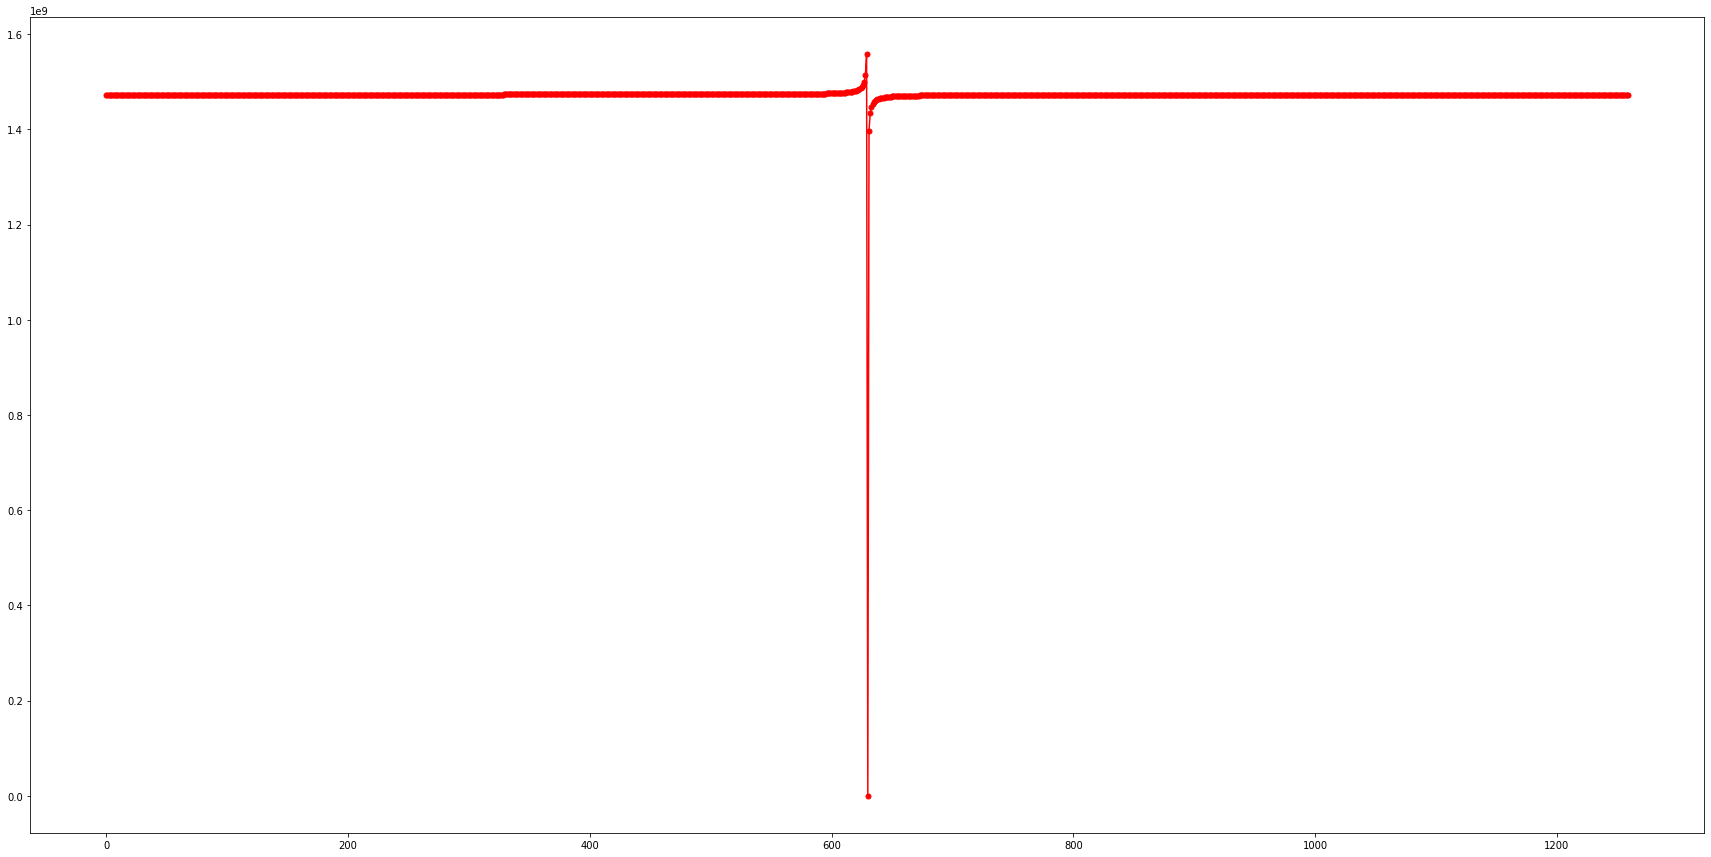

In [302]:
fig1,axes1 = plt.subplots(1,1)
axes1.plot((1/delta_omega_Im-np.min(1/delta_omega_Im)),'r.-',ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)

plt.show()

In [299]:
np.argmax(delta_omega_Im)

1259

In [300]:
np.max(delta_omega_Im)

0.3257556874213742

In [301]:
delta_omega_Re[np.argmax(delta_omega_Im)]

197427.13301022552

4234.078007413111
0.05414679003395008


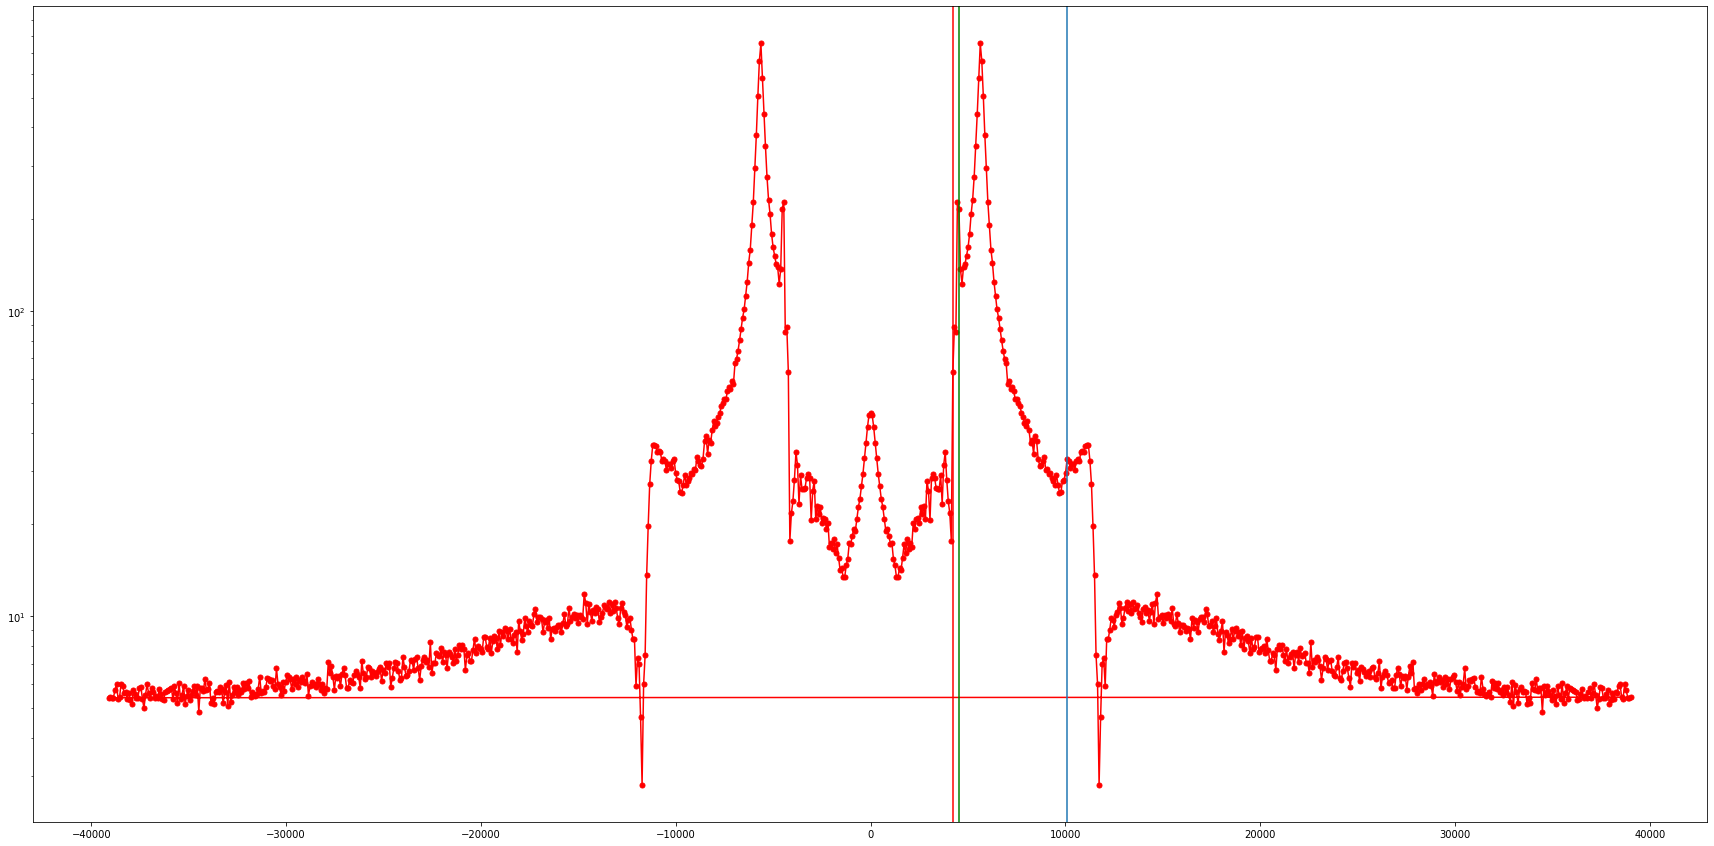

In [235]:
gamma_fft = np.fft.fft(first_gamma[rng1:rng2]-Gamma0)
w = np.fft.fftfreq(len(first_gamma[rng1:rng2]),d=1/f0)
rng1 =  0
rng2 = int(3000)
step1 = 1

fig1,axes1 = plt.subplots(1,1)
axes1.plot(w[rng1:rng2],np.abs(gamma_fft[rng1:rng2]),'r.-',ms=10)
axes1.set_yscale('log')
axes1.axvline(x=Qs*f0+delta_omega_Re[0]/2/pi)
axes1.axvline(x=Qs*f0,color='r')

axes1.axvline(x=Qs*f0+delta_omega_Re[np.argmax(delta_omega_Im)]/2/pi,color='g')

fig1.set_figheight(15)
fig1.set_figwidth(30)
print(Qs*f0)
print(Qs)
plt.show()

In [184]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
with open(datafile, mode='rb') as file: # b is important -> binary
    test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

time = np.array(test[0::n_stride])
Ibi = np.array(test[1::n_stride])
#Ibi_1 = np.array(test[2::n_stride])
Ibi2 = np.array(test[3::n_stride])

V = []
Ig = []
#U = []
Vref = []
Iref = []
Power = []
for i in range(nRF):
    V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
    Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
    #U.append(np.array(test[1+2*nBeam+2+i*3::n_stride]))
    print(V0[i],V0Q[i])
    Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
    Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))
    Power.append(V[i]*Ig[i])


52769936.95709294 -2192554.7217137115
-29316631.64282941 -1218085.9565076174


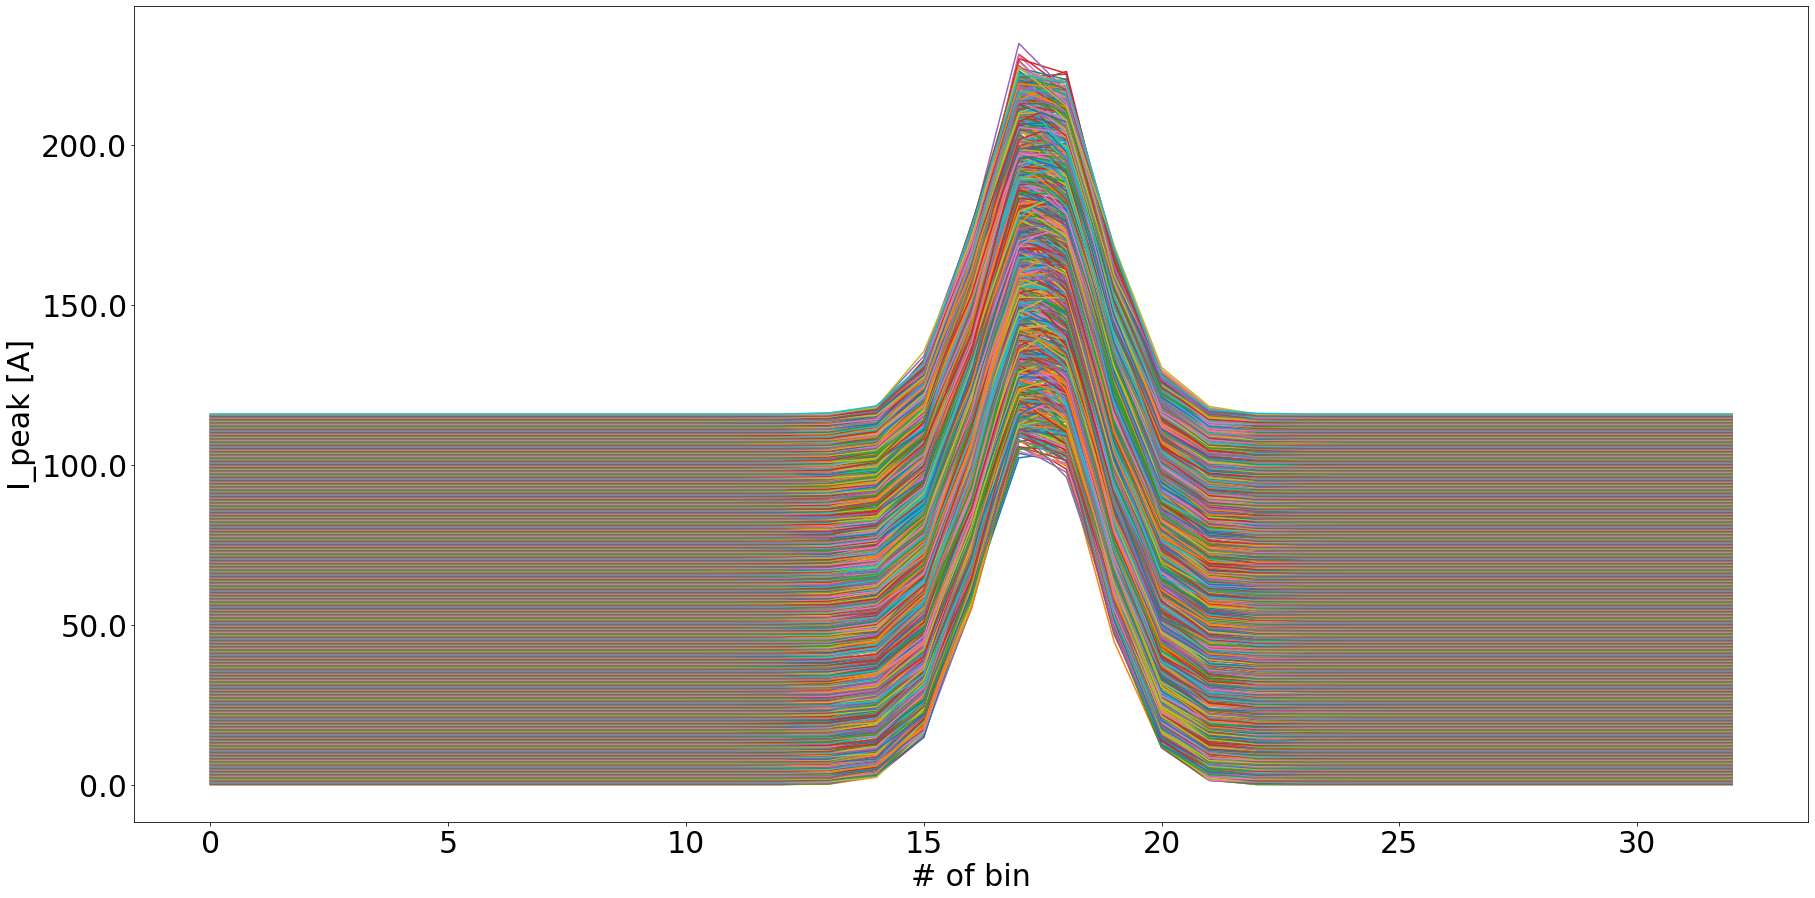

In [94]:
startTurn =128#int((nfill+n_q_ramp)/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(int(nBunch/1)):
    startRF = i*fill_step*1
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1]+0.1*i,ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_before = os.path.join(cwd,'before.jpg')
plt.savefig(fn_before,bbox_inches='tight')
plt.show()


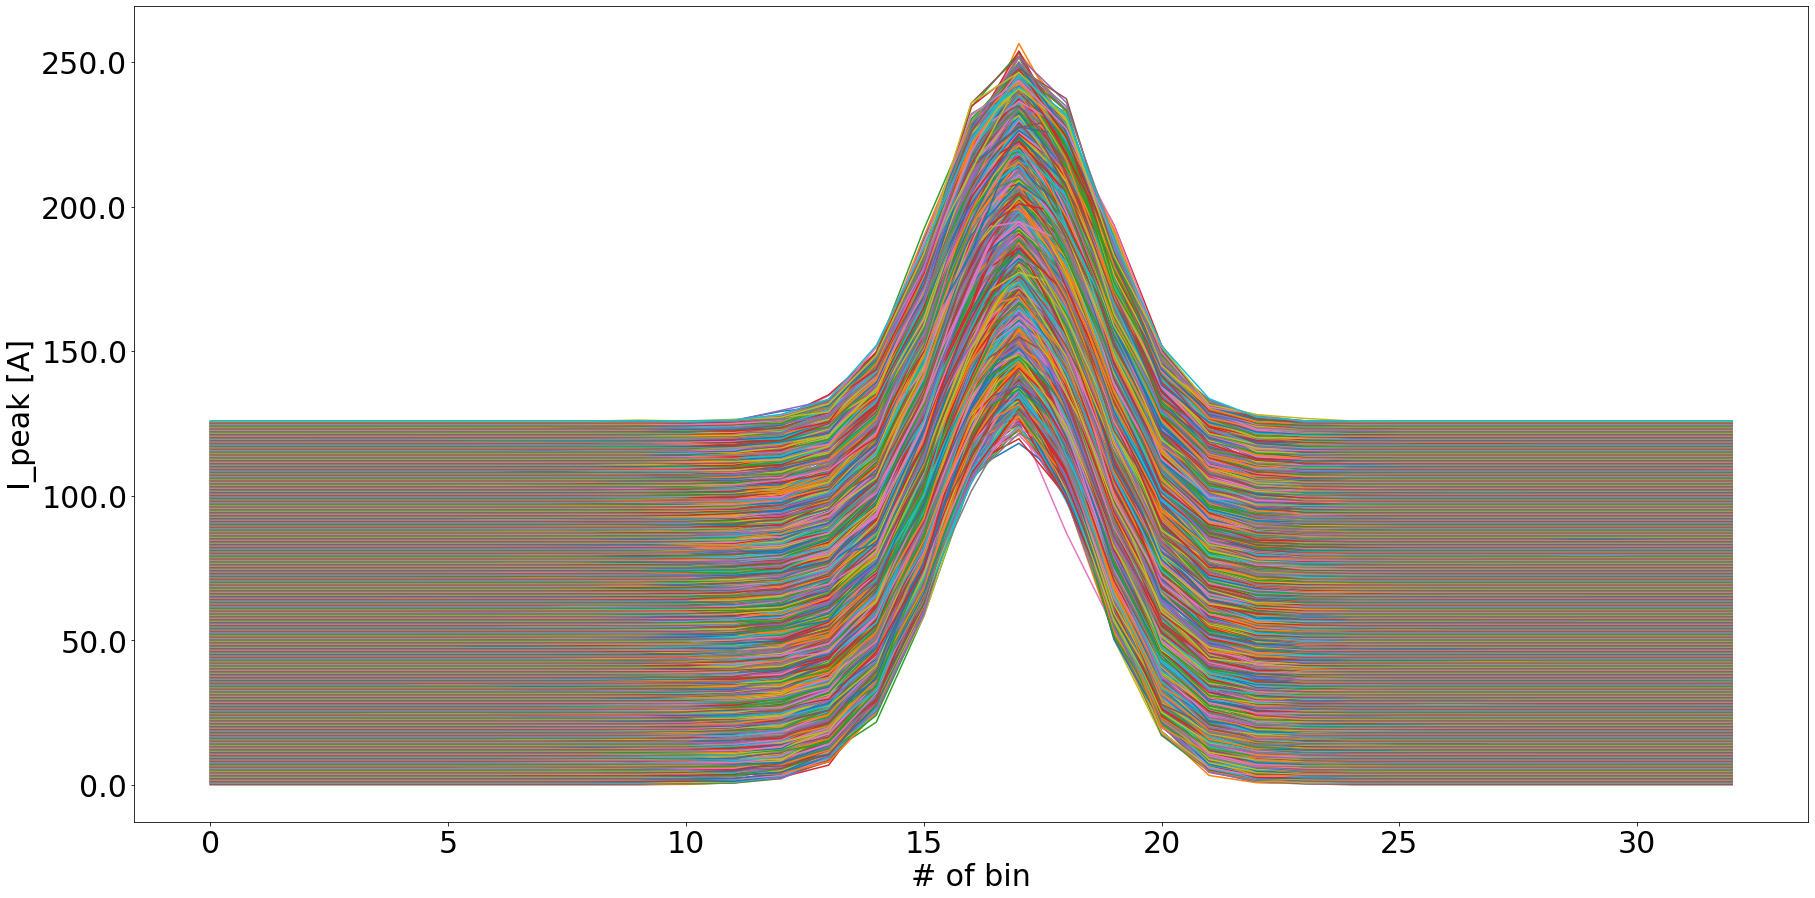

In [222]:
startTurn =174#int(nTurns/step-1)
startRF = 0
nRFsamp = 1
fig1,axes1 = plt.subplots(1,1)

for i in range(int(nBunch/1)):
    startRF = i*fill_step*1
    rng1 = NpRF*(h[0]*startTurn+startRF)+int(NpRF/4)*0+0
    rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(NpRF/4)*0-0
    axes1.plot(Ibi[rng1:rng2:step1]+0.1*i,ms=10)

fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.tick_params(labelsize=50)

axes1.set_xlabel('# of bin',fontsize=30)
axes1.set_ylabel('I_peak [A]',fontsize=30)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fn_after = os.path.join(cwd,'after.jpg')
plt.savefig(fn_after,bbox_inches='tight')
plt.show()

In [211]:
np.argmax(delta_omega_Im)

1259

In [212]:
np.max(delta_omega_Im)

0.6035098420131835

In [213]:
delta_omega_Re[np.argmax(delta_omega_Im)]

-36.34082504650944

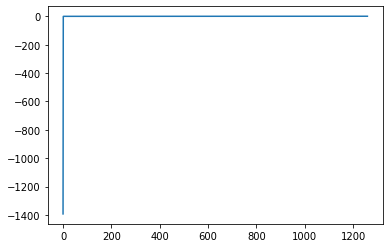

In [214]:
plt.plot(delta_omega_Im)
plt.show()

In [282]:
step_fine = 100
omega_fine = np.array([i*step_fine for i in range(int(2*600e6/step_fine))])*2*pi
omega_fine[0] = 1e-16
omega_fine = np.append(omega_fine,-omega_fine[1:])

In [283]:
Z_fine = Zparallel(R[0],QL[0],omegac[0],omega_fine)

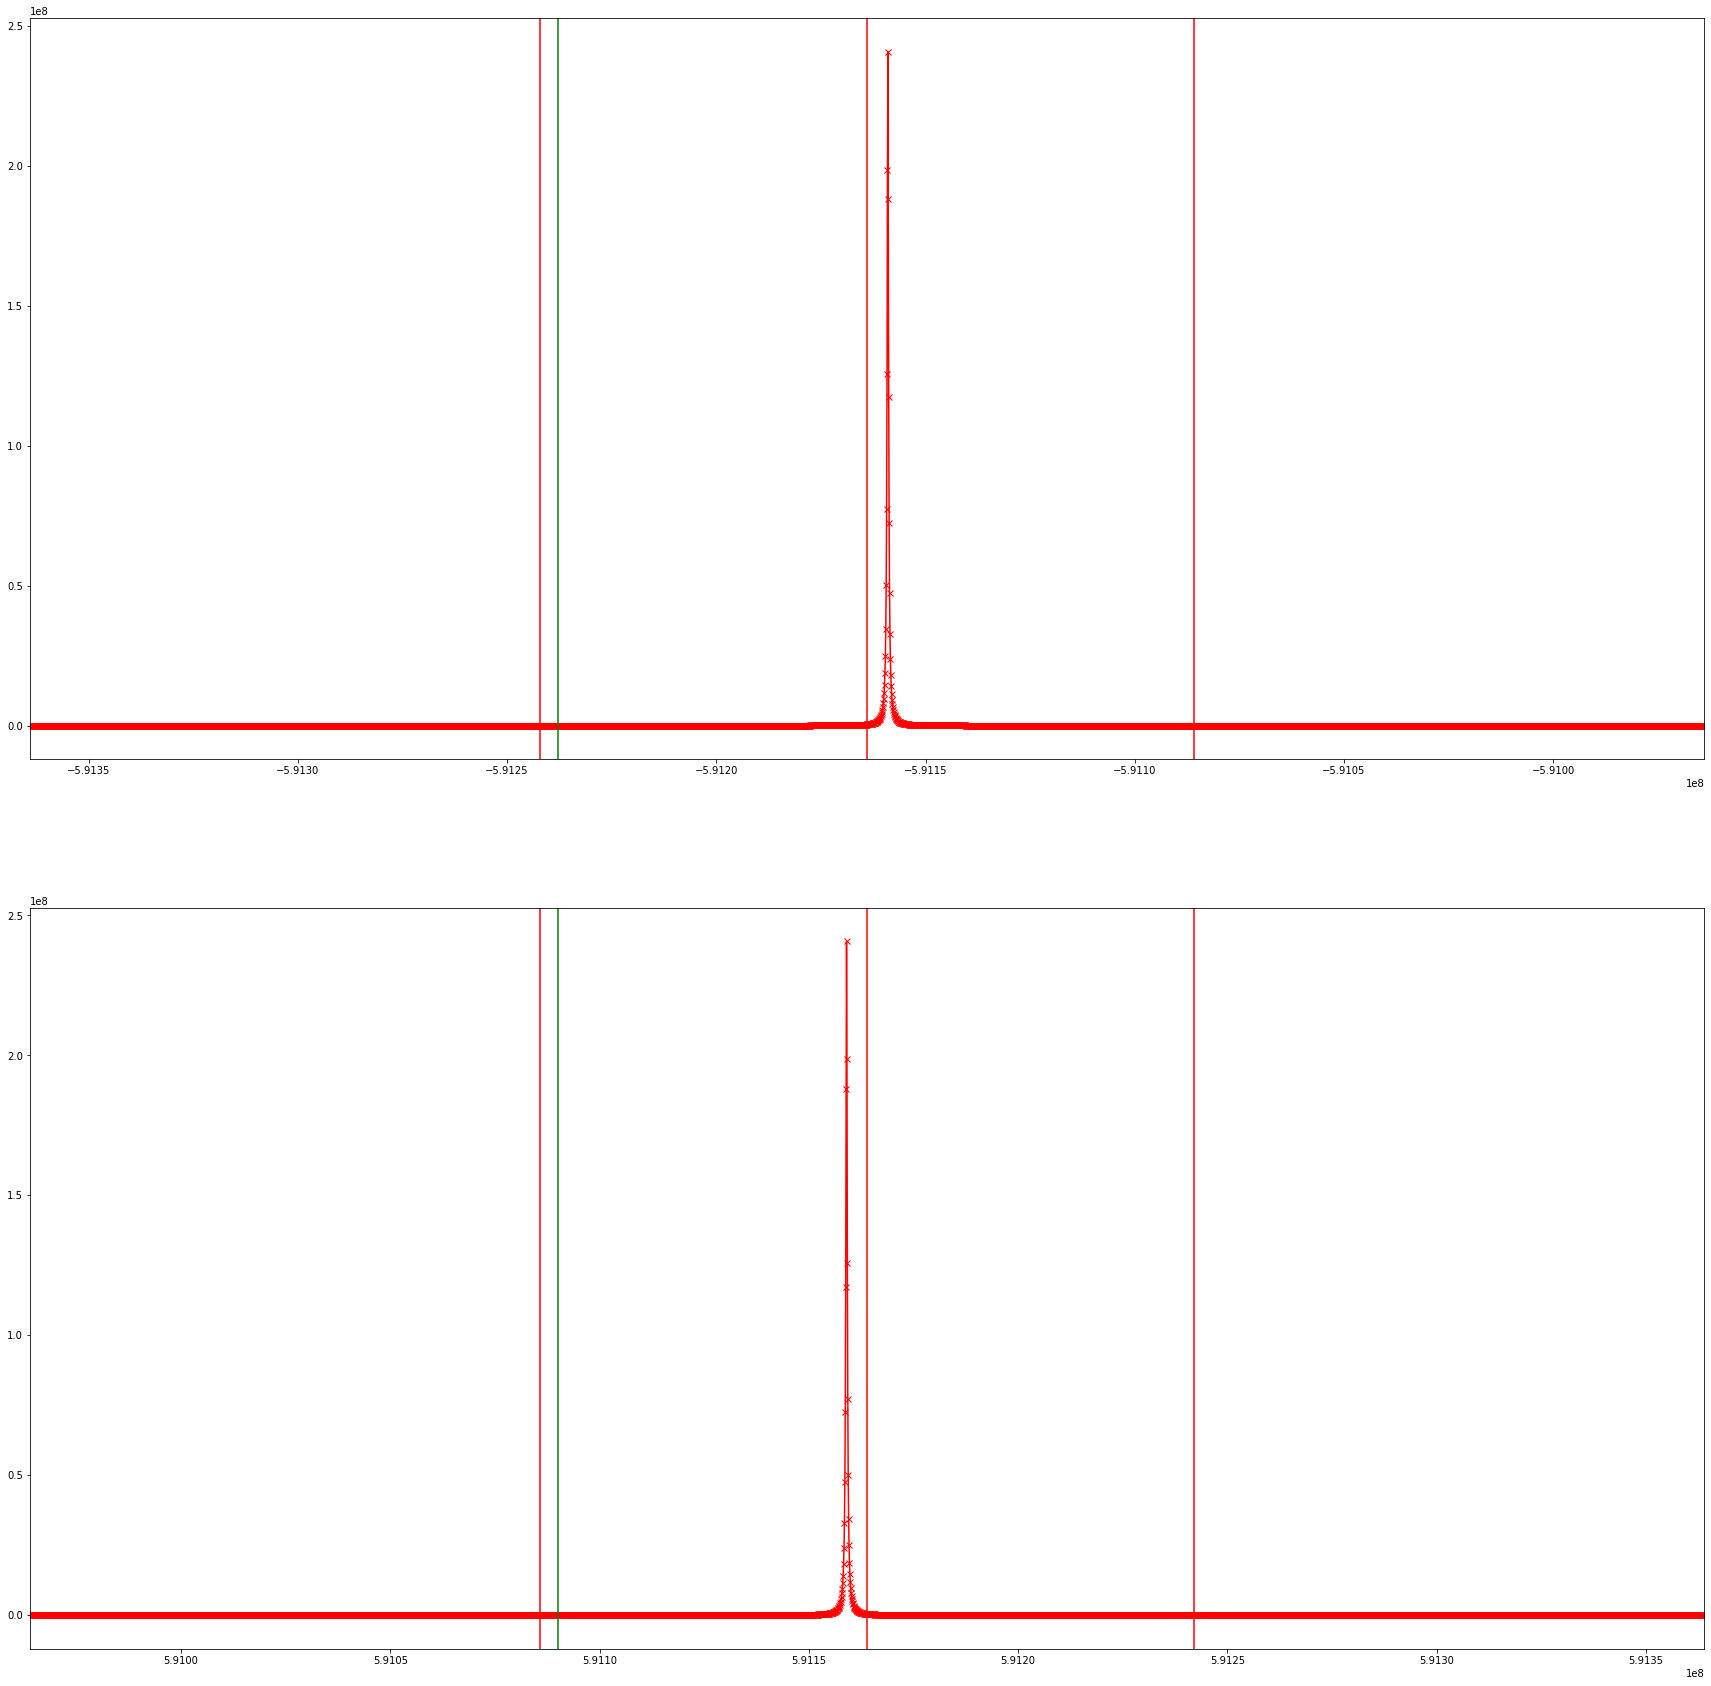

In [284]:
frq1 = h[0]*f0-2e5
frq2 = h[0]*f0+2e5
rng1 = int((frq1)/step_fine)
rng2 = int((frq2)/step_fine)
fig,axe1 = plt.subplots(2)
axe1[0].plot(omega_fine[rng1:rng2]/2/pi,(np.real(Z_fine[rng1:rng2])),'rx-')
axe1[0].plot(omega_fine[rng1+int(len(omega_fine)/2):rng2+int(len(omega_fine)/2)]/2/pi,(np.real(Z_fine[rng1+int(len(omega_fine)/2):rng2+int(len(omega_fine)/2)])),'rx-')

axe1[0].axvline(x = -h[0]*f0,color='r')
axe1[0].axvline(x = -h[0]*f0-f0,color='r')
axe1[0].axvline(x = -h[0]*f0+f0,color='r')

#axe1[0].axvline(x = -h[0]*f0-detune_final[0],color='blue')
for i in range(len(omegas1)):
    axe1[0].axvline(x = omegas2[i]/2/pi,color='g')

axe1[0].set_xlim([-(frq2),-(frq1)])

axe1[1].plot(omega_fine[rng1:rng2]/2/pi,(np.real(Z_fine[rng1:rng2])),'rx-')
axe1[1].plot(omega_fine[rng1+int(len(omega_fine)/2):rng2+int(len(omega_fine)/2)]/2/pi,(np.real(Z_fine[rng1+int(len(omega_fine)/2):rng2+int(len(omega_fine)/2)])),'rx-')

axe1[1].axvline(x = h[0]*f0,color='r')
axe1[1].axvline(x = h[0]*f0-f0,color='r')
axe1[1].axvline(x = h[0]*f0+f0,color='r')

#axe1[1].axvline(x = h[0]*f0+detune_final[0],color='blue')
for i in range(len(omegas1)):
    axe1[1].axvline(x = omegas2[i]/2/pi,color='g')

axe1[1].set_xlim([(frq1),(frq2)])

fig.set_figheight(30)
fig.set_figwidth(30)

plt.show()